# 가위바위보 이미지를 딥러닝 학습시키기


## *목차


#### 1.각 패키지 불러오기
#### 2.모든 경로 설정하기
#### 3.학습 및 테스트 데이터셋 준비, 전처리
#### 4.딥러닝 네트워크 설계하기
#### 5.훈련
#### 6.추론
#### 7.실험결과
#### 8.결론
#### 9.논의사항

## 1. 각 패키지 설치 및 불러오기

In [4]:
!pip install pillow  
from PIL import Image
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 2. 모든 경로 설정하기

##### ubuntu home path : ubuntu home 의 경로
##### train images path : 학습 이미지들의 경로
##### test images path : 테스트 이미지들의 경로

In [4]:
ubuntu_home_path = os.getenv("HOME")   # ./home/aiffel
train_images_path = ubuntu_home_path + "/aiffel/exp1_rock_scissor_paper/images/rock_scissor_paper_train"
test_images_path = ubuntu_home_path + "/aiffel/exp1_rock_scissor_paper/images/rock_scissor_paper_test"

## 3.학습 및 테스트 데이터셋 준비, 전처리
#### 1)이미지 촬영 및 다운로드 (https://teachablemachine.withgoogle.com/), 경로설정
#### 2)학습이미지 resize(224x224x3 >> 28x28x3)
#### 3)학습이미지  label(0/1/2), 메모리 올리기
#### 4)이미지 normalize

In [6]:
# 2) 학습이미지 resize

# 1 장의 이미지를 resize 하는 함수
def resize_image(img):
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")


target_size=(28,28)  # 28*28로 resize
directories = ['rock', 'scissor', 'paper']  # 3개 폴더 모두 적용

# 가위 바위 보 3 폴더에 대해서 resize 진행
for dir in directories:   # rock, scissor, paper 3개 폴더에 대해서
    images = glob.glob(train_images_path + "/" + dir + "/*.jpg")  # 폴더 안의 모든 사진을
    for img in images:
        resize_image(img)   # resize
print("rock scissor paper resize finished")

resize finished


In [7]:
# 3) 학습 이미지 label, x_train, y_train 설정

def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

In [9]:
# 4) 이미지 올리기, normalize

# x_train, y_train 설정
(x_train, y_train)=load_data(train_images_path)
# x_train normalize
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train_norm shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train_norm shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  2
[[107 106 111]
 [109 107 110]
 [110 108 111]
 [114 108 110]
 [119 110 113]
 [124 112 114]
 [130 114 115]
 [135 114 113]
 [106  80  79]
 [ 86  56  54]
 [100  66  64]
 [ 84  46  43]
 [ 99  58  54]
 [100  56  53]
 [ 94  49  44]
 [ 94  49  44]
 [ 90  55  61]
 [134 102 107]
 [160 131 135]
 [148 126 128]
 [155 139 139]
 [123 113 111]
 [126 122 119]
 [140 141 136]
 [138 143 137]
 [137 142 138]
 [135 140 136]
 [133 138 134]]


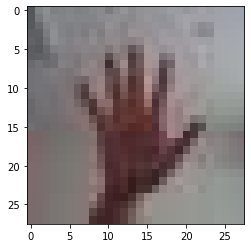

In [10]:
# image test

n = 210

plt.imshow(x_train[n])
print('라벨: ', y_train[n])
print(x_train[n][14])

In [3]:
# norm image test

n = 100

plt.imshow(x_train_norm[n])
print('라벨: ', y_train[n])
print(x_train_norm[n][14])

NameError: name 'x_train_norm' is not defined

## 4. 딥러닝 네트워크 설계
#### MNIST 와 동일하나, hyperparameter 수정

In [14]:
n_channel_1 = 16
n_channel_2 = 32    # 
n_dense = 32   # 
n_train_epoch = 10
input_image_shape = (28,28,3)  # rgb 3 channel
classes_number = 3  # rock scissor paper

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=input_image_shape))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_2, (5,5), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(classes_number, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## 5.Train

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 1.0760 - accuracy: 0.4500
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.9961 - accuracy: 0.8000
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.8773 - accuracy: 0.7100
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.7105 - accuracy: 0.7967
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.8533
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.8733
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.8733
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4056 - accuracy: 0.8867
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8500
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8800


## 6.Test

In [18]:
# test image dataset 세팅

print("test 이미지 디렉토리 경로: ", test_images_path)
(x_test, y_test)=load_data(test_images_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("x_test_norm shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

test 이미지 디렉토리 경로:  /home/aiffel/aiffel/exp1_rock_scissor_paper/images/rock_scissor_paper_test
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
x_test_norm shape: (300, 28, 28, 3)
y_test shape: (300,)


In [19]:
# Test 진행

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.0939 - accuracy: 0.3667
test_loss: 2.0939366817474365 
test_accuracy: 0.36666667461395264


## 7.결과


#### 1) 학습 데이터셋의 양 (2000 vs 100)
1-1)
1-2)

#### 2) 학습 이미지 해상도(224 vs 28)
2-1)
2-2)

#### 3) normalize vs non-normalize
3-1)
3-2)


// 2000 vs 100

// 224 vs 28 

// normalize 한 경우
1.내 사진(각100)으로 학습, 보배님 사진(각100)으로 test
 : accuracy 0.367
2.다운로드 사진(각2000)으로 학습, 내 사진(각100)으로 test
 : accuracy 
 
 
// normalize 하지 않았을 경우

## 8.결론

##### 1.학습 데이터셋의 양이 증가함에 따라, 학습 성능이 증가한다.
##### 2.학습 데이터셋의 해상도가 증가함에 따라, 학습 성능이 증가한다.
##### 3.학습 시, 다양한 데이터 셋을 normalize 하여 학습함에 따라, 학습 성능이 증가한다.

## 9.논의

#### 1.과연 가위바위보를 분류하는데 딥러닝을 적용하는게 맞는 것일까?
손을 인식하기 위한 딥러닝 분류를 적용하는 것은 맞다고 맞다.
그런데 어찌보면 가위바위보는 손가락 숫자를 counting 하는 것이다
어떤 사람은 가위를 엄지/검지로 하고 어떤 사람은 검지/중지로 한다.
손을 인식하고, 해당 box 안에 손가락을 counting 하는 것은 다른 기존의 영상처리법으로 하는게 낫지 않을까??


#### 2.손 사진을 28 * 28 * 3 으로 resize/reshape 하는 것이 적절할까?
resize 사진을 보면 사람도 구분하기 애매한 것들이 많다.
오리지날 image가 224 * 224 * 3 이니까 정도면 직접 학습하면 어떨까? 학습시간은 오래걸리겠지만 성능은 낫지 않을까


#### 3.이미지 레이블 박스 처리를 해줬어야하지 않나?
손 사진을 학습시킬때, 사실 28*28 모든 픽셀을 학습에 사용하였지만, 실제 손 사진은 
즉, 이미지 레이블 박스를 치지 않았다.
이 과정에서 훈련 데이터 셋이 전처리가 깔끔하게 되었다고 보기 힘들다.

#### 4.normalize 할때 255 로 나누기만 하면 될까?
이미지 내 최대 밝기/최소밝기가 있다면, max>>1, min>>0 사이의 값으로 normalize하는게 맞지 않을까